# Handwritten Digit Classfication using Convolutional Neural Network

The tutorial presented will again tackle the MNIST digit classification problem. You can find more information from the previous [MNIST introduction](introduction_to_mnist.ipynb) tutorial. This time, we will build a Convolutional Neural Network which is vastly used in many different applications. CNN are networks with loops in them, allowing information to persist. Take a look at [this great blog](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) to gain insights of CNN.

In [1]:
import matplotlib
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.criterion import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext

from zoo.common.nncontext import *
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import *
from zoo.pipeline.api.autograd import *

sc = get_nncontext()

Populating the interactive namespace from numpy and matplotlib
Using /home/lizhichao/bin/spark-2.1.0-bin-hadoop2.7
Adding /home/lizhichao/bin/god/zoo/dist/lib/zoo-0.1.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Adding /home/lizhichao/bin/god/zoo/dist/lib/zoo-0.1.0-SNAPSHOT-jar-with-dependencies.jar to SPARK_CLASSPATH


In [5]:
def get_mnist(sc, mnist_path):
    # target is start from 0,
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    (test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")
    training_mean = np.mean(train_images)
    training_std = np.std(train_images)
    rdd_train_images = sc.parallelize(train_images)
    rdd_train_labels = sc.parallelize(train_labels)
    rdd_test_images = sc.parallelize(test_images)
    rdd_test_labels = sc.parallelize(test_labels)
    
    rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
    rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
    return (rdd_train_sample, rdd_test_sample)

## 1. Train the network

First, we should get and store MNIST into RDD of Sample.

Note: *edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory*.

In [6]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "/tmp/.keras/datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print train_data.count()
print test_data.count()

('Extracting', '/tmp/.keras/datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/tmp/.keras/datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/tmp/.keras/datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/tmp/.keras/datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


## 2. Model creation

Let's create the LeNet-5 model.

In [21]:
def build_model(class_num):
    input1 = Input((28, 28, 1))
    reshape = Reshape((1, 28, 28))(input1)
    conv1 = Convolution2D(6, 5, 5, activation="tanh", name="conv1_5x5")(reshape)
    pool1 = MaxPooling2D()(conv1)
    conv2 = Convolution2D(12, 5, 5, activation="tanh", name="conv2_5x5")(pool1)
    pool2 = MaxPooling2D()(conv2)
    flatten = Flatten()(pool2)
    fc1 = Dense(100, activation="tanh", name="fc1")(flatten)
    fc2 = Dense(class_num, activation="softmax", name="fc2")(fc1)
    return Model(input1, fc2)

lenet_model = build_model(10)

creating: createZooKerasInput
creating: createZooKerasReshape
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel


## 3. Optimizer setup and training

In [23]:
# Compile the model
lenet_model.compile(optimizer=SGD(learningrate=0.4, learningrate_decay=0.0002),
                  loss=ClassNLLCriterion(logProbAsInput=False),
                  metrics=["accuracy"])
app_name='lenet-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = '/tmp/zoo_summaries'
lenet_model.set_tensorboard(log_dir, app_name)
lenet_model.save_graph_topology(log_dir)
print "saving logs to ",app_name

creating: createDefault
creating: createSGD
creating: createClassNLLCriterion
creating: createTop1Accuracy
saving logs to  lenet-20180509-171234


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [24]:
%%time
# Boot training process
lenet_model.fit(x=train_data,
              batch_size=2048,
              nb_epoch=20,
              validation_data=test_data)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 1min 54s


## 4. Predication on test data

In [12]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

Let's first take a few traing samples and check the labels

Ground Truth labels:
5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0


(-0.5, 223.5, 27.5, -0.5)

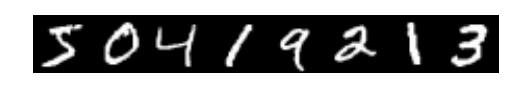

In [13]:
# label-1 to restore the original label.
print "Ground Truth labels:" 
print ', '.join([str(map_groundtruth_label(s.label.to_ndarray())) for s in train_data.take(8)])
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in train_data.take(8)]),cmap='gray'); plt.axis('off')

Now, let's see the prediction results on test data by our trained model.

Ground Truth labels:
7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 548 ms


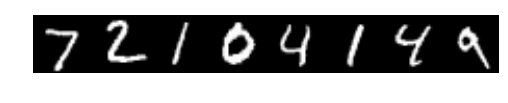

In [15]:
%%time
predictions = lenet_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))

## 5. Model inspection

In [25]:
#tensorboard --logdir=/tmp/zoo_summaries